# Fully Connected Deep Neural Networks
## Deep Learning
#  Carlos Álvarez

### **Git-hub: https://github.com/Alvarez527**
### **Linkedin: www.linkedin.com/in/cralvarez-ai**

#### Activity 1a: Implementing a Multilayer Fully Connected Network using Numpy
#### Non-graded activity (0 points)

- Objective

The primary objective of this activity is to deepen your understanding of Fully Connected Networks by implementing a multilayer network using only Numpy. You  are  given  the follosing starter code that solves the MNIST dataset problem. Your task is to read, understand, and then apply this knowledge to solve classification problems on other datasets such as the Kaggle ASL dataset (Starter code will be provided separately for that activity).

- Instructions

    Read and Understand the following Code: The provided starter code outlines the architecture of a Fully Connected Network designed to classify MNIST images. Go through the code to understand how each function and class is used to implement the network.

    Understand the Math: Make sure you understand the math operations implemented in the code, especially during the forward and backward passes. This will involve matrix multiplications, activation functions, loss computations, and backpropagation.
    
- Experiment
    You are encouraged to play with the code, change any hyperparameters and train the model, you should be able to achieve over 95% accuracy on the test set without problems.


In [62]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Import Images

In [64]:
from get_images import get_images

In [65]:
### Obtain the data and convert it to numpy matrix

In [66]:
# MNIST path
mnist_path = './mnist_raw/'
x_train_num, y_train_num, x_test_num, y_test_num = get_images(mnist_path)

In [67]:
print(f'X_train shape: {x_train_num.shape}, Y_train shape: {y_train_num.shape}, X_test shape: {x_test_num.shape}, Y_test shape: {y_test_num.shape}')

X_train shape: (60000, 28, 28), Y_train shape: (60000,), X_test shape: (10000, 28, 28), Y_test shape: (10000,)


In [68]:

##The matrices are converted to one-dimensional arrays to simplify code handling.
##With the .astype(float) operation, the binary data is converted to real values, allowing for ML operations.

x_train = x_train_num[:50000].reshape(50000, -1).astype(float)
y_train = y_train_num[:50000].reshape(50000, 1)

x_val = x_train_num[50000:].reshape(10000, -1).astype(float)
y_val = y_train_num[50000:].reshape(10000, 1)

x_test = x_test_num.copy().reshape(10000, -1).astype(float)
y_test = y_test_num.copy().reshape(10000, 1)

In [69]:

#The mean, standard deviation, and minimum value are obtained to normalize the data afterward.
x_train.mean(), x_train.std(), x_train.min()

(33.39512885204082, 78.6661972212754, 0.0)

In [70]:

#This function will normalize the real data stored in the one-dimensional arrays.
def normalise(x_mean, x_std, x_data):
    return (x_data - x_mean) / x_std

In [71]:
#The arrays are nomalized here
x_mean = x_train.mean()
x_std = x_train.std()

x_train = normalise(x_mean, x_std, x_train)
x_val = normalise(x_mean, x_std, x_val)
x_test = normalise(x_mean, x_std, x_test)

In [72]:
#We confirm here that the values are normalized, mean is near zero and the std. dev. is almost 1.
x_train.mean(), x_train.std()

(-9.646705203355238e-18, 0.9999999999999997)

### Plot samples

In [74]:
def plot_number(image):
    plt.figure(figsize=(5,5))
    plt.imshow(image.squeeze(), cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.show()

La imagen muestreada representa un: 2


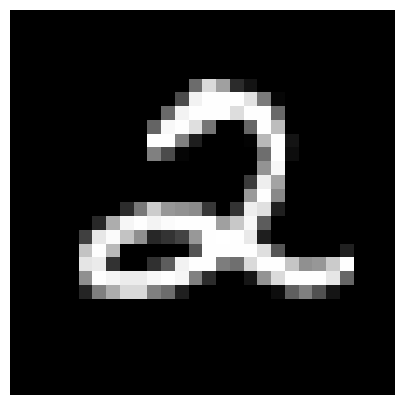

In [75]:
rnd_idx = np.random.randint(len(y_test))
print(f'La imagen muestreada representa un: {y_test[rnd_idx, 0]}')
plot_number(x_test_num[rnd_idx])

### Equations


$$z^1 = W^1 X + b^1$$

$$a^1 = ReLU(z^1) $$

$$z^2 = W^2 a^1 + b^2$$

$$\hat{y} = \frac{e^{z^{2_k}}}{\sum_j{e^{z_j}}}$$


$$ \mathcal{L}(\hat{y}^{i}, y^{i}) =  - y^{i}  \ln(\hat{y}^{i}) = -\ln(\hat{y}^i)$$


$$ \mathcal{J}(w, b) =  \frac{1}{num\_samples} \sum_{i=1}^{num\_samples}-\ln(\hat{y}^{i})$$

### Helper functions

#### Creat Mini batches

In [79]:
def create_minibatches(mb_size, x, y, shuffle = True):
    '''
    x  #muestras, 784
    y #muestras, 1
    '''
    assert x.shape[0] == y.shape[0], 'Error en cantidad de muestras'
    total_data = x.shape[0]
    if shuffle: 
        idxs = np.arange(total_data)
        np.random.shuffle(idxs)
        x = x[idxs]
        y = y[idxs]  
    return ((x[i:i+mb_size], y[i:i+mb_size]) for i in range(0, total_data, mb_size))

## Nuestra clase Linear, ReLU y Sequential

In [81]:
#Se crea una clase que hereda de np.ndarray, tiene todas las características de numpy mas los comportamientos que se le agreguen
class np_tensor(np.ndarray): pass

In [82]:
a = np.array([0, 0])
b = a.view(np_tensor)

In [83]:
type(a)

numpy.ndarray

In [84]:
type(b)

__main__.np_tensor

In [85]:
a == b

np_tensor([ True,  True])

In [86]:
a is b

False

###  Clase Linear

In [88]:
#The formula np.random.randn(m, n) / np.sqrt(n / 2) is a form of scaling that takes into account the number of 
#inputs and outputs of the node, helping to avoid the problem of exploding or vanishing gradients during the training of deep networks.

#The result of the formula (np.zeros((output_size, 1))).view(np_tensor) is that b holds a column vector of zeros wrapped as an np_tensor, 


class Linear():
    def __init__(self, input_size, output_size):
        '''
        Init parameters utilizando Kaiming He
        '''
        self.W = (np.random.randn(output_size, input_size) / np.sqrt(input_size/2)).view(np_tensor)
        self.b = (np.zeros((output_size, 1))).view(np_tensor)
    def __call__(self, X): # esta el foward de la clase lineal
        Z = self.W @ X + self.b
        return Z
    def backward(self, X, Z):
        X.grad = self.W.T @ Z.grad
        self.W.grad = Z.grad @ X.T
        self.b.grad = np.sum(Z.grad, axis = 1, keepdims=True)    
    

In [89]:
a = Linear(200, 50)

a.W.shape

(50, 200)

### Clase ReLU

In [91]:
#__call__(self, Z): Applies the ReLU activation function, replacing the negative values of 
#Z with 0 and leaving the positive values unchanged.

#backward(self, Z, A): Calculates the gradient of the ReLU activation function with respect to 𝑍
#during the backpropagation step. It sets the gradients to 0 for the negative values of 𝑍
#and copies the gradients for the positive values of Z.

class ReLU():
    def __call__(self, Z):
        return np.maximum(0, Z)
    def backward(self, Z, A):
        Z.grad = A.grad.copy()
        Z.grad[Z <= 0] = 0

### Clase Sequential

In [93]:
#This class stores a list of layers that could be a Relu or Linear object and will iterate on this list in order to execute the forward pass or
#the backward propagation, storing the values of the corresponding activations of each layer.

#This class make it possible to update the values of the W,b during the backward propagation in order to optimize the cost function value.
class Sequential_layers():
    def __init__(self, layers):
        '''
        layers - lista que contiene objetos de tipo Linear, ReLU
        '''
        self.layers = layers
        self.x = None
        self.outputs = {}
    def __call__(self, X):
        self.x = X 
        self.outputs['l0'] = self.x
        for i, layer in enumerate(self.layers, 1):
            self.x = layer(self.x)
            self.outputs['l'+str(i)]=self.x
        return self.x
    def backward(self):
        for i in reversed(range(len(self.layers))):
            self.layers[i].backward(self.outputs['l'+str(i)], self.outputs['l'+str(i+1)])
            
#This function implements SGD in order to update the values of W and b
    
    def update(self, learning_rate = 1e-3):
        for layer in self.layers:
            if isinstance(layer, ReLU): continue
            layer.W = layer.W - learning_rate * layer.W.grad
            layer.b = layer.b - learning_rate * layer.b.grad
    def predict(self, X):
        return np.argmax(self.__call__(X))            

### Cost Function

In [118]:
def softmaxXEntropy(x, y):
    batch_size = x.shape[1]
    exp_scores = np.exp(x)
    probs = exp_scores / exp_scores.sum(axis = 0)
    preds = probs.copy()
    # Costo
    y_hat = probs[y.squeeze(), np.arange(batch_size)]
    cost = np.sum(-np.log(y_hat)) / batch_size
    # Calcular gradientes
    probs[y.squeeze(), np.arange(batch_size)] -= 1 #dl/dx
    x.grad = probs.copy()
    
    return preds, cost

### Loop de entrenamiento

In [120]:
def train(model, epochs, mb_size=128, learning_rate = 1e-3):
    for epoch in range(epochs):
        for i, (x, y) in enumerate(create_minibatches(mb_size, x_train, y_train)):
            scores = model(x.T.view(np_tensor))
            _, cost = softmaxXEntropy(scores, y)
            model.backward()
            model.update(learning_rate)
        print(f'costo: {cost}, accuracy: {accuracy(x_val, y_val, mb_size)}')

In [122]:
def accuracy(x, y, mb_size):
    correct = 0
    total = 0
    for i, (x, y) in enumerate(create_minibatches(mb_size, x, y)):
        pred = model(x.T.view(np_tensor))
        correct += np.sum(np.argmax(pred, axis=0) == y.squeeze())
        total += pred.shape[1]
    return correct/total

In [124]:
model = Sequential_layers([Linear(784, 300), ReLU(), Linear(300, 200), ReLU(), Linear(200, 200), ReLU(), Linear(200, 10)])
mb_size = 512
learning_rate = 1e-4
epochs = 20


In [126]:
train(model, epochs, mb_size, learning_rate)

costo: 0.3284643835210912, accuracy: 0.9244
costo: 0.26039396352231625, accuracy: 0.9447
costo: 0.12535420526047042, accuracy: 0.9531
costo: 0.12382602276732327, accuracy: 0.9584
costo: 0.11620818629882901, accuracy: 0.9608
costo: 0.08465203308294231, accuracy: 0.9626
costo: 0.14598565201377547, accuracy: 0.9646
costo: 0.07296848433983474, accuracy: 0.9678
costo: 0.11111835089370577, accuracy: 0.9685
costo: 0.04389763516597965, accuracy: 0.9687
costo: 0.05322368266512506, accuracy: 0.9705
costo: 0.0488735261827562, accuracy: 0.9724
costo: 0.04388396149042868, accuracy: 0.9718
costo: 0.06682132470307815, accuracy: 0.9726
costo: 0.05653012433950611, accuracy: 0.9728
costo: 0.052543153938846884, accuracy: 0.9729
costo: 0.047831881246832166, accuracy: 0.9733
costo: 0.055718207748911244, accuracy: 0.9741
costo: 0.08179626050610604, accuracy: 0.9741
costo: 0.03929473500676297, accuracy: 0.9751


In [128]:
print(accuracy(x_test, y_test, mb_size))

0.9718


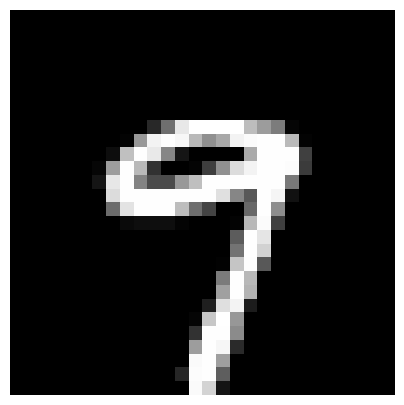

el valor predicho es: 9, el valor real es:9


In [130]:
idx = np.random.randint(len(y_test))
plot_number(x_test_num[idx])
pred = model.predict(x_test[idx].reshape(-1, 1))
print(f'el valor predicho es: {pred}, el valor real es:{y_test[idx][0]}')